In [1]:
dataset = "ALFTS"

In [2]:
from MRF import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
close_prices = pd.read_csv(f"/Users/ryanlucas/Desktop/MacroRandomForest/Datasets/ALFTS.csv")['spy_close']

In [5]:
data_in = pd.read_csv(f"/Users/ryanlucas/Desktop/MacroRandomForest/Datasets/ALFTS.csv")

In [6]:
rows_of_interest = 0

In [7]:
data_in = data_in.iloc[rows_of_interest:, 1:]
close_prices = close_prices.iloc[rows_of_interest:]

In [8]:
data_in = data_in.reset_index(drop = True)
close_prices = close_prices.reset_index(drop = True)

In [9]:
data_in.iloc[:, 1:11] = data_in.iloc[:, 1:11].diff()
data_in.iloc[:, 12:23] = data_in.iloc[:, 12:23].diff()
data_in.iloc[:, -1] = data_in.iloc[:, -1].diff()

In [10]:
data_in = data_in.fillna(0)

1617    0.006136
1618    0.010498
1619    0.004660
1620   -0.000350
1621   -0.002038
          ...   
2112    0.009911
2113   -0.002125
2114    0.001877
2115    0.001165
2116    0.000769
Name: 0, Length: 500, dtype: float64

In [12]:
oos_pos = np.arange(data_in.index[-500], data_in.index[-1]+1)

In [13]:
MRF = MacroRandomForest(data = data_in,
                        y_pos = 0,
                        x_pos = np.arange(1, 5), 
                        fast_rw = True, 
                        B = 50, 
                        mtry_frac = 0.3, 
                        resampling_opt = 2,
                        oos_pos = oos_pos, 
                        trend_push = 1,
                        quantile_rate = 0.3, 
                        print_b = True, 
                        parallelise = True,
                        n_cores = 2)

In [14]:
mrf_output = MRF._ensemble_loop()

In [15]:
def financial_evaluation(model_forecasts, close_prices, oos_pos):
    '''
    Method for generating signals and backtesting the financial performance of MRF
    '''

    daily_profit = []

    T_profit = np.arange(1, len(oos_pos)+1)

    for t in T_profit:

        # Produce a trading signal and calculate daily profit.
        daily_profit.append(trading_strategy(model_forecasts=model_forecasts,
                                                stock_price=close_prices,
                                                k=1,
                                                t=t))

    daily_profit = pd.Series(daily_profit)
    cumulative_profit = daily_profit.cumsum()
    annualised_return = get_annualised_return(
        cumulative_profit, T_profit)

    sharpe_ratio = get_sharpe_ratio(daily_profit)
    max_drawdown = get_max_dd_and_date(
        cumulative_profit)

    # Return the output.
    return daily_profit, cumulative_profit, annualised_return, sharpe_ratio, max_drawdown

def get_sharpe_ratio(daily_profit):
    mean = daily_profit.mean()
    std_dev = daily_profit.std()
    return 252**(0.5)*mean/std_dev


def get_max_dd_and_date(cumulative_profit):
    rolling_max = (cumulative_profit+1).cummax()
    period_drawdown = (
        ((1+cumulative_profit)/rolling_max) - 1).astype(float)
    drawdown = round(period_drawdown.min(), 3)
    return drawdown

def get_annualised_return(cumulative_profit, T_profit):
    return cumulative_profit.iloc[-1]*(252/len(T_profit))

def trading_strategy(model_forecasts, stock_price, t, k=1):

    PL_t = 0
    signal_t_minus_1 = 0

    # Long if return prediction > 0 ; otherwise short.
    for i in range(1, k+1):
        if model_forecasts.iloc[t-i] > 0:
            signal_t_minus_1 += 1
        elif model_forecasts.iloc[t-i] < 0:
            signal_t_minus_1 -= 1

    PL_t += (1/k)*signal_t_minus_1 * \
        ((stock_price[t] - stock_price[t-1])/stock_price[t-1])

    return PL_t

<AxesSubplot:>

Text(0.5, 1.0, 'Backtested MRF trading strategy')

Text(0, 0.5, 'Cumulative Profit')

Text(0.5, 0, 'OOS $t$')

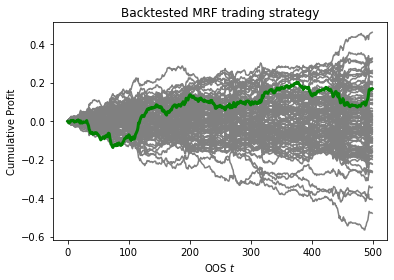

In [16]:
fig, ax = plt.subplots()

for i in range(1, 100):
    plots = financial_evaluation(pd.Series(np.random.normal(0, 1, size = len(oos_pos))), close_prices, oos_pos)[0].cumsum().plot(ax = ax, color = 'grey')

    if i == 100:
        plots = financial_evaluation(pd.Series(np.random.normal(0, 1, size = len(oos_pos))), close_prices, oos_pos)[0].cumsum().plot(ax = ax, color = 'grey')
MRF.financial_evaluation(close_prices)[0].cumsum().plot(ax = ax, linewidth = 3, color = 'green')

ax.set_title("Backtested MRF trading strategy")
ax.set_ylabel("Cumulative Profit")
ax.set_xlabel(r"OOS $t$")
plt.rcParams['figure.figsize'] = (11,8)

In [184]:
observed_y = pd.DataFrame(data_in[0].loc[oos_pos]).shift(1)

In [185]:
observed_y.reset_index(inplace = True)

In [186]:
del observed_y['index']

In [187]:
zeros = pd.Series(np.zeros(100))

In [204]:
MRF.financial_evaluation(close_prices)

(0     -0.002086
 1     -0.004865
 2     -0.003123
 3      0.003242
 4      0.002656
          ...   
 495    0.004570
 496   -0.003810
 497    0.001746
 498   -0.000139
 499    0.003310
 Length: 500, dtype: float64,
 0     -0.002086
 1     -0.006951
 2     -0.010074
 3     -0.006831
 4     -0.004176
          ...   
 495    0.166479
 496    0.162668
 497    0.164415
 498    0.164276
 499    0.167585
 Length: 500, dtype: float64,
 0.08446290272246634,
 0.758095689650895,
 -0.143)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

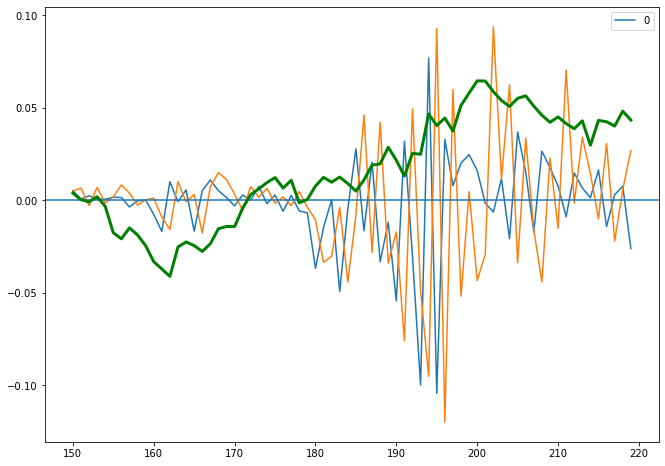

In [202]:
fig, ax = plt.subplots()


mrf_output['pred'].iloc[150:220].plot(ax = ax)
observed_y.iloc[150:220].plot(ax = ax)
ax.axhline(y = 0)
MRF.financial_evaluation(close_prices)[0].cumsum().plot(ax = ax, linewidth = 3, color = 'green')


In [189]:
errors = observed_y.subtract(mrf_output['pred'], axis = 0)

In [190]:
observed_y.reset_index(inplace = True)

In [191]:
del observed_y['index']

In [192]:
observed_y

,0
0,NaN
1,0.006136
2,0.010498
3,0.004660
4,-0.000350
...,...
495,-0.000784
496,0.009911
497,-0.002125
498,0.001877


In [193]:
(observed_y.subtract(mrf_output['pred'], axis = 0)**2).mean()

0    0.000582
dtype: float64

In [194]:
(observed_y**2).mean()

0    0.000272
dtype: float64

In [195]:
profile_code = False
if profile_code:
    %load_ext line_profiler
    %lprun -f MRF._splitter_mrf MRF._one_MRF_tree(1)

In [196]:
phils_preds = pd.read_csv("/Users/ryanlucas/Desktop/MRF/predictions_s1.csv", index_col = "Unnamed: 0")

In [197]:
my_preds = pd.DataFrame(mrf_output['pred_ensemble'])